<a href="https://colab.research.google.com/github/mahdishafiei/Brain-Tomur-Semantic-segmentation/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt

import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow.keras.metrics as metrics

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/data/'
image_path = os.path.join(path, './crossimage/')
mask_path = os.path.join(path, './crossmask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
image_list.sort()
mask_list = [mask_path+i for i in mask_list]
mask_list.sort()

In [ ]:
IMG_WIDTH = 800
IMG_HEIGHT = 512
IMG_CHANNELS = 3

In [ ]:
X_train = np.zeros((314, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((314, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [ ]:
Y_train.shape

(314, 512, 800, 1)

In [ ]:
print('Resizing training images ')
n=0
for i in image_list:
    img = imread(i)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    n += 1

Resizing training images 


In [ ]:
print('Resizing masks.. ')
n=0
for i in mask_list:
    img = imread(i)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
    Y_train[n] = img  #Fill empty X_train with values from img
    n += 1

Resizing masks.. 


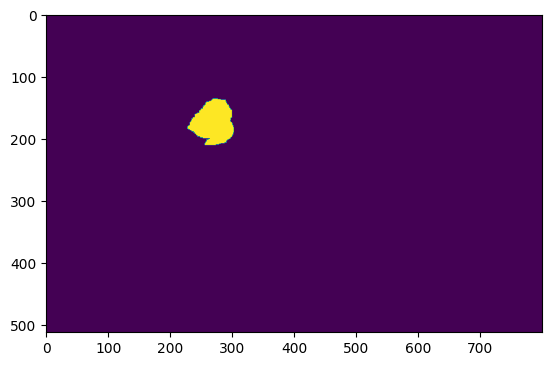

In [ ]:
plt.imshow(np.squeeze(Y_train[120,:,:,:]))


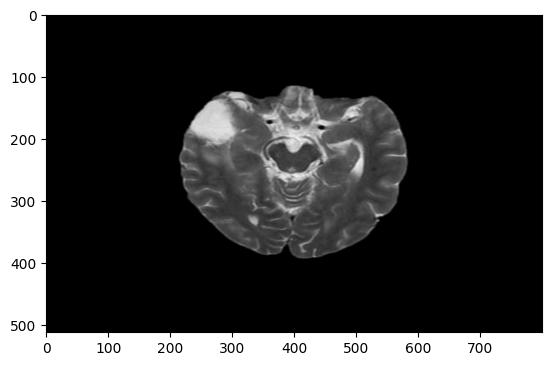

In [ ]:
plt.imshow(X_train[120,:,:,:]);

In [ ]:
pip install focal-loss


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 33.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.6.11 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
orbax-checkpoint 0.2.6 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.


In [ ]:
from focal_loss import BinaryFocalLoss

### **U-Net Model**

In [ ]:

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=BinaryFocalLoss(gamma=2), metrics=[metrics.Precision(),'accuracy'])
model.summary()

################################



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 800, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 800, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import tensorflow.keras.metrics as met

In [ ]:
# Hausdorff distance

import numpy as np
from scipy.spatial.distance import directed_hausdorff

# Assuming you have two four-dimensional tensors representing the ground truth and predicted segmentation masks
# Shape: (batch_size, height, width, num_classes)
def Hausdorff(ground_truth_masks,predicted_masks):

  # Convert the tensors to pixel coordinates
  ground_truth_coords = []
  predicted_coords = []

  for batch in range(ground_truth_masks.shape[0]):
      ground_truth_mask = ground_truth_masks[batch]
      predicted_mask = predicted_masks[batch]

      # Get the coordinates for each class in the ground truth mask
      for class_idx in range(ground_truth_mask.shape[-1]):
          coords = np.transpose(np.nonzero(ground_truth_mask[:, :, class_idx]))
          ground_truth_coords.append(coords)

      # Get the coordinates for each class in the predicted mask
      for class_idx in range(predicted_mask.shape[-1]):
          coords = np.transpose(np.nonzero(predicted_mask[:, :, class_idx]))
          predicted_coords.append(coords)

  # Concatenate the coordinates for all classes and batches
  ground_truth_coords = np.concatenate(ground_truth_coords, axis=0)
  predicted_coords = np.concatenate(predicted_coords, axis=0)

  # Calculate the Hausdorff distance
  hausdorff_distance = max(directed_hausdorff(ground_truth_coords, predicted_coords)[0],
                          directed_hausdorff(predicted_coords, ground_truth_coords)[0])

  return hausdorff_distance


#Surface Dice

import numpy as np

def surface_dice_coefficient(ground_truth, predicted):
    intersection = np.sum(ground_truth * predicted)
    ground_truth_sum = np.sum(ground_truth)
    predicted_sum = np.sum(predicted)

    dice_coefficient = (2 * intersection) / (ground_truth_sum + predicted_sum)

    return dice_coefficient

# Assuming you have two four-dimensional tensors representing the ground truth and predicted segmentation masks
# Shape: (batch_size, height, width, num_classes)
def surface(ground_truth_masks,predicted_masks):

  # Calculate the Surface Dice coefficient for each sample in the batch
  batch_size = ground_truth_masks.shape[0]
  surface_dice_coefficients = []

  for i in range(batch_size-1):
      ground_truth_mask = ground_truth_masks[i]
      predicted_mask = predicted_masks[i]

      surface_dice = surface_dice_coefficient(ground_truth_mask, predicted_mask)
      surface_dice_coefficients.append(surface_dice)

  # Calculate the average Surface Dice coefficient across the batch
  average_surface_dice = np.mean(surface_dice_coefficients)
  return average_surface_dice

In [ ]:
scores_CNN={"accuracy":[],"precision":[],"recall":[],"f1":[],"confusion_matrix":[],"Hausdorff":[],"Surface":[]}

In [ ]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=BinaryFocalLoss(gamma=2), metrics=[met.Precision(),'accuracy'])

In [ ]:
tf.keras.metrics.Precision(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)

In [ ]:
from tensorflow.keras.metrics import Precision

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/scores_CNN.pkl', 'rb') as handle:
    scores_CNN = pickle.load(handle)

EOFError: ignored

In [ ]:
scores_CNN

{'accuracy': [],
 'precision': [],
 'recall': [],
 'f1': [],
 'confusion_matrix': [],
 'Hausdorff': [],
 'Surface': []}

In [ ]:
# fix random seed for reproducibility

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True,random_state=10)
history = list()
for train, test in kfold.split(X_train,y= [0] * 314):
	Y_tr = Y_train[train]
	Y_te = Y_train[test]
	X_tr = X_train[train]
	X_te = X_train[test]
	model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
	model.compile(optimizer='adam', loss=BinaryFocalLoss(gamma=2), metrics=[met.Precision(),'accuracy'])
	result = model.fit(X_tr, Y_tr,
                    batch_size = 16,
                    verbose=1,
                    epochs=10,
                    shuffle=False)


	print("Next Model ------------------------------------------------------------------------------------------------")
	# evaluate the model
	train_predict = model.predict(X_te, verbose=1)
	preds_train_t = (train_predict > 0.5).astype(int)
	scores_CNN["accuracy"].append(model.evaluate(X_te, Y_te, verbose=1)[2]*100)
	scores_CNN["confusion_matrix"].append(metrics.confusion_matrix(Y_te.reshape(-1).astype(int), preds_train_t.reshape(-1)))
	scores_CNN["recall"].append(metrics.recall_score(Y_te.reshape(-1).astype(int),preds_train_t.reshape(-1)))
	scores_CNN["precision"].append(metrics.precision_score(Y_te.reshape(-1).astype(int),preds_train_t.reshape(-1)))
	scores_CNN["f1"].append(metrics.f1_score(Y_te.reshape(-1).astype(int), preds_train_t.reshape(-1)))
	scores_CNN["Hausdorff"].append(Hausdorff(Y_te,train_predict))
	scores_CNN["Surface"].append(surface(Y_te.astype(int),train_predict.astype(int)))
	with open('/content/gdrive/MyDrive/scores_CNN.pkl', 'wb') as fp:
		pickle.dump(scores_CNN, fp)

Epoch 1/10
16/16 [==============================] - 1471s 89s/step - loss: 0.2359 - precision_3: 0.0262 - accuracy: 0.9711
Epoch 2/10
16/16 [==============================] - 1390s 87s/step - loss: 0.2430 - precision_3: 0.0000e+00 - accuracy: 0.9849
Epoch 3/10
16/16 [==============================] - 1392s 87s/step - loss: 0.2430 - precision_3: 0.0000e+00 - accuracy: 0.9849
Epoch 4/10
16/16 [==============================] - 1388s 87s/step - loss: 0.2430 - precision_3: 0.0000e+00 - accuracy: 0.9849
Epoch 5/10
16/16 [==============================] - 1389s 87s/step - loss: 0.2430 - precision_3: 0.0000e+00 - accuracy: 0.9849
Epoch 6/10
16/16 [==============================] - 1390s 87s/step - loss: 0.2430 - precision_3: 0.0000e+00 - accuracy: 0.9849
Epoch 7/10
16/16 [==============================] - 1394s 87s/step - loss: 0.2430 - precision_3: 0.0000e+00 - accuracy: 0.9849
Epoch 8/10
16/16 [==============================] - 1380s 86s/step - loss: 0.2430 - precision_3: 0.0000e+00 - accur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
16/16 [==============================] - 1370s 85s/step - loss: 0.2613 - precision_4: 0.0000e+00 - accuracy: 0.9838
Epoch 2/10
16/16 [==============================] - 1354s 85s/step - loss: 0.2613 - precision_4: 0.0000e+00 - accuracy: 0.9838
Epoch 3/10
16/16 [==============================] - 1349s 84s/step - loss: 0.2613 - precision_4: 0.0000e+00 - accuracy: 0.9838
Epoch 4/10
16/16 [==============================] - 1360s 85s/step - loss: 0.2613 - precision_4: 0.0000e+00 - accuracy: 0.9838
Epoch 5/10
16/16 [==============================] - 1354s 84s/step - loss: 0.2613 - precision_4: 0.0000e+00 - accuracy: 0.9838
Epoch 6/10
16/16 [==============================] - 1351s 84s/step - loss: 0.2613 - precision_4: 0.0000e+00 - accuracy: 0.9838
Epoch 7/10
16/16 [==============================] - 1361s 85s/step - loss: 0.2613 - precision_4: 0.0000e+00 - accuracy: 0.9838
Epoch 8/10
16/16 [==============================] - 1354s 84s/step - loss: 0.2613 - precision_4: 0.0000e+00 - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
16/16 [==============================] - 1373s 85s/step - loss: 0.2658 - precision_5: 0.0000e+00 - accuracy: 0.9835
Epoch 2/10
 7/16 [============>.................] - ETA: 13:00 - loss: 0.1576 - precision_5: 0.0000e+00 - accuracy: 0.9902

In [ ]:
scores_CNN

NameError: ignored

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/scores_CNN.pkl', 'wb') as fp:
    pickle.dump(scores_CNN, fp)

NameError: ignored

In [ ]:
scores_CNN

In [ ]:
j= 44
plt.imshow(X_train[j,:,:,:]);
plt.show()
plt.imshow(np.squeeze(Y_train[j,:,:,:]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[j,:,:,:]))
plt.show()
plt.imshow(np.squeeze(train_predict[j,:,:,:]))
plt.show()

NameError: ignored

In [ ]:
i = 0 # from zero to (number of fold) -1
# summarize history for accuracy
plt.plot(history[i].history['accuracy'])
plt.plot(history[i].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history[i].history['loss'])
plt.plot(history[i].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()